In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    median_absolute_error
)


In [ ]:
# Constants

RANDOM_SEED = 42
TEST_SIZE = 0.30
CV_FOLDS = 3
np.random.seed(RANDOM_SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/EDUC 244 Final Project/raw data/2025.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

Dataset shape: (478370, 46)

Columns: ['CAD Event Number', 'CAD Event Clearance Description', 'Call Type', 'Priority', 'Initial Call Type', 'Final Call Type', 'CAD Event Original Time Queued', 'CAD Event Arrived Time', 'Dispatch Precinct', 'Dispatch Sector', 'Dispatch Beat', 'Dispatch Longitude', 'Dispatch Latitude', 'Dispatch Reporting Area', 'CAD Event Response Category', 'Call Sign Dispatch ID', 'Call Sign Dispatch Time', 'First CARE Call Sign At Scene Time', 'First CARE Call Sign Dispatch Time', 'First Co-Response Call Sign At Scene Time', 'First Co-Response Call Sign Dispatch Time', 'First SPD Call Sign at Scene Time', 'First SPD Call Sign Dispatch Time', 'Last CARE Call Sign In-Service Time', 'Last Co-Response Call Sign In-Service Time', 'Last SPD Call Sign In-Service Time', 'CARE Call Sign Total Service Time (s)', 'Co-Response Call Sign Total Service Time (s)', 'SPD Call Sign Total Service Time (s)', 'Call Sign Total Service Time (s)', 'First CARE Call Sign Dispatch Delay Time (

In [ ]:
target_col = 'CAD Event First Response Time (s)'

df_clean = df.copy()
df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')

# Remove invalid values and outliers
df_clean = df_clean.dropna(subset=[target_col])
df_clean = df_clean[df_clean[target_col] > 0]
lower, upper = df_clean[target_col].quantile([0.01, 0.99])
df_clean = df_clean[(df_clean[target_col] >= lower) & (df_clean[target_col] <= upper)]

print(f"Target: {target_col}")
print(f"Records: {len(df_clean):,}")
print(f"Mean: {df_clean[target_col].mean():.0f}s ({df_clean[target_col].mean()/60:.1f} min)")
print(f"Median: {df_clean[target_col].median():.0f}s ({df_clean[target_col].median()/60:.1f} min)")

Target: CAD Event First Response Time (s)
Records: 177,510
Mean: 393s (6.5 min)
Median: 366s (6.1 min)


In [ ]:
# Cleaning Features

categorical_features = [
    'Call Type',
    'Priority',
    'Initial Call Type',
    'Dispatch Precinct',
    'Dispatch Sector',
    'Dispatch Beat',
    'Dispatch Neighborhood',
    'CAD Event Response Category',
    'Call Type Indicator',
    'Call Type Received Classification'
]

numeric_features = [
    'Dispatch Longitude',
    'Dispatch Latitude',
    'Dispatch Reporting Area'
]

time_col = 'CAD Event Original Time Queued'

# Check to ensure that all columns exist and pull all data
categorical_features = [f for f in categorical_features if f in df_clean.columns]
numeric_features = [f for f in numeric_features if f in df_clean.columns]
if time_col not in df_clean.columns:
    time_col = None

print(f"Categorical: {len(categorical_features)}")
print(f"Numeric: {len(numeric_features)}")
print(f"Time: {time_col}")


Categorical: 10
Numeric: 3
Time: CAD Event Original Time Queued


In [ ]:
df_model = df_clean.copy()
engineered_features = []


if time_col:
    df_model[time_col] = pd.to_datetime(df_model[time_col], errors='coerce')
    df_model['hour_of_day'] = df_model[time_col].dt.hour
    df_model['day_of_week'] = df_model[time_col].dt.dayofweek
    df_model['month'] = df_model[time_col].dt.month
    df_model['is_weekend'] = (df_model['day_of_week'] >= 5).astype(int)
    df_model['is_night'] = ((df_model['hour_of_day'] >= 22) | (df_model['hour_of_day'] <= 6)).astype(int)
    df_model['is_rush_hour'] = (((df_model['hour_of_day'] >= 7) & (df_model['hour_of_day'] <= 9)) |
                                 ((df_model['hour_of_day'] >= 16) & (df_model['hour_of_day'] <= 18))).astype(int)
    engineered_features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend', 'is_night', 'is_rush_hour']


encoded_categorical = []
for col in categorical_features:
    df_model[col] = df_model[col].fillna('Unknown').astype(str)
    df_model[f"{col}_encoded"] = LabelEncoder().fit_transform(df_model[col])
    encoded_categorical.append(f"{col}_encoded")


for col in numeric_features:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')
    df_model[col] = df_model[col].fillna(df_model[col].median())

all_features = encoded_categorical + numeric_features + engineered_features
print(f"Total features: {len(all_features)}")



/tmp/ipython-input-2067310187.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_model[time_col] = pd.to_datetime(df_model[time_col], errors='coerce')


Total features: 19


In [ ]:

X = df_model[all_features].fillna(0).replace([np.inf, -np.inf], 0)
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

Train: 124,257 | Test: 53,253


In [2]:
# Helper Function to Display Metrics after Each Model
# Credit to Claude (Anthropic) for Formatting of Print Statements

def display_metrics(name, y_true, y_pred, y_train_true=None, y_train_pred=None):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true[y_true != 0] - y_pred[y_true != 0]) / y_true[y_true != 0])) * 100

    print(f"\n{'='*55}")
    print(f"  {name}")
    print(f"{'='*55}")
    print(f"  RMSE:      {rmse:>8.2f}s ({rmse/60:.2f} min)")
    print(f"  MAE:       {mae:>8.2f}s ({mae/60:.2f} min)")
    print(f"  Median AE: {medae:>8.2f}s ({medae/60:.2f} min)")
    print(f"  R²:        {r2:>8.4f}")
    print(f"  MAPE:      {mape:>8.2f}%")

    if y_train_true is not None and y_train_pred is not None:
        r2_train = r2_score(y_train_true, y_train_pred)
        print(f"\n  R² Train: {r2_train:.4f} | R² Test: {r2:.4f} | Diff: {r2_train - r2:.4f}")

    abs_errors = np.abs(y_true - y_pred)
    print(f"\n  Within ±1 min: {(abs_errors <= 60).mean()*100:.1f}%")
    print(f"  Within ±2 min: {(abs_errors <= 120).mean()*100:.1f}%")
    print(f"  Within ±5 min: {(abs_errors <= 300).mean()*100:.1f}%")

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MedianAE': medae, 'MAPE': mape}


In [3]:
# Model 1: Ridge

# First Gridsearch for best alpha then test
ridge_grid = GridSearchCV(
    Ridge(random_state=RANDOM_SEED),
    {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    cv=CV_FOLDS, scoring='r2', n_jobs=-1
)
ridge_grid.fit(X_train_scaled, y_train)

print(f"Best params: {ridge_grid.best_params_}")
print(f"Best CV R²: {ridge_grid.best_score_:.4f}")
ridge_model = ridge_grid.best_estimator_
ridge_pred_train = ridge_model.predict(X_train_scaled)
ridge_pred_test = ridge_model.predict(X_test_scaled)

ridge_metrics = display_metrics("RIDGE REGRESSION", y_test, ridge_pred_test, y_train, ridge_pred_train)



NameError: name 'GridSearchCV' is not defined

In [ ]:
# Model 2: Random Forest

# First hyperparameter tune then test

X_sample = X_train.sample(frac=0.05, random_state=RANDOM_SEED)
y_sample = y_train.loc[X_sample.index]

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1),
    {'max_depth': [10, 15], 'min_samples_leaf': [2, 5]},
    cv=3, scoring='r2', n_jobs=-1
)
rf_grid.fit(X_sample, y_sample)

print(f"Best params: {rf_grid.best_params_}")
print(f"Best CV R²: {rf_grid.best_score_:.4f}")


rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=rf_grid.best_params_['max_depth'],
    min_samples_leaf=rf_grid.best_params_['min_samples_leaf'],
    min_samples_split=10,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

rf_metrics = display_metrics("RANDOM FOREST", y_test, rf_pred_test, y_train, rf_pred_train)

rf_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Top 10):")
for i, (_, row) in enumerate(rf_importance.head(10).iterrows(), 1):
    print(f"  {i:2}. {row['Feature']:<35} {row['Importance']:.4f}")

Best params: {'max_depth': 15, 'min_samples_leaf': 2}
Best CV R²: 0.3651

  RANDOM FOREST
  RMSE:        186.00s (3.10 min)
  MAE:         139.96s (2.33 min)
  Median AE:   113.09s (1.88 min)
  R²:          0.5212
  MAPE:         96.75%

  R² Train: 0.5988 | R² Test: 0.5212 | Diff: 0.0775

  Within ±1 min: 32.6%
  Within ±2 min: 52.2%
  Within ±5 min: 88.1%

Feature Importance (Top 10):
   1. Call Type Received Classification_encoded 0.2036
   2. Call Type Indicator_encoded         0.1878
   3. Priority_encoded                    0.1413
   4. Initial Call Type_encoded           0.0996
   5. Dispatch Latitude                   0.0780
   6. Dispatch Longitude                  0.0515
   7. hour_of_day                         0.0450
   8. Dispatch Reporting Area             0.0430
   9. Dispatch Beat_encoded               0.0303
  10. month                               0.0295


In [ ]:
# Model 3: Gradient Boost

# First hyperparameter tune then test
# Note: I used Gradient Boost instead of XGboost as I wanted to try out the model
# ... I now understand why people prefer XGboost as this model was incredibly slow

X_sample = X_train.sample(frac=0.05, random_state=RANDOM_SEED)
y_sample = y_train.loc[X_sample.index]

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_SEED),
    {'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]},
    cv=3, scoring='r2', n_jobs=-1
)
gb_grid.fit(X_sample, y_sample)

print(f"Best params: {gb_grid.best_params_}")
print(f"Best CV R²: {gb_grid.best_score_:.4f}")


gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=gb_grid.best_params_['max_depth'],
    learning_rate=gb_grid.best_params_['learning_rate'],
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_SEED
)
gb_model.fit(X_train, y_train)

gb_pred_train = gb_model.predict(X_train)
gb_pred_test = gb_model.predict(X_test)

gb_metrics = display_metrics("GRADIENT BOOSTING", y_test, gb_pred_test, y_train, gb_pred_train)

gb_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Top 10):")
for i, (_, row) in enumerate(gb_importance.head(10).iterrows(), 1):
    print(f"  {i:2}. {row['Feature']:<35} {row['Importance']:.4f}")

Best params: {'learning_rate': 0.05, 'max_depth': 5}
Best CV R²: 0.3561

  GRADIENT BOOSTING
  RMSE:        210.01s (3.50 min)
  MAE:         164.83s (2.75 min)
  Median AE:   143.44s (2.39 min)
  R²:          0.3897
  MAPE:        222.79%

  R² Train: 0.3943 | R² Test: 0.3897 | Diff: 0.0046

  Within ±1 min: 26.5%
  Within ±2 min: 43.6%
  Within ±5 min: 83.6%

Feature Importance (Top 10):
   1. Call Type Indicator_encoded         0.3392
   2. Call Type Received Classification_encoded 0.2173
   3. Priority_encoded                    0.2065
   4. Initial Call Type_encoded           0.0860
   5. Dispatch Latitude                   0.0288
   6. Dispatch Precinct_encoded           0.0262
   7. Dispatch Beat_encoded               0.0245
   8. hour_of_day                         0.0216
   9. Dispatch Neighborhood_encoded       0.0155
  10. Call Type_encoded                   0.0093


In [ ]:
# Model Comparison
# Print statements and graphing with help from Claude (Anthropic)

comparison_df = pd.DataFrame({
    'Model': ['Ridge Regression', 'Random Forest', 'Gradient Boosting'],
    'RMSE (s)': [ridge_metrics['RMSE'], rf_metrics['RMSE'], gb_metrics['RMSE']],
    'MAE (s)': [ridge_metrics['MAE'], rf_metrics['MAE'], gb_metrics['MAE']],
    'Median AE (s)': [ridge_metrics['MedianAE'], rf_metrics['MedianAE'], gb_metrics['MedianAE']],
    'R² Score': [ridge_metrics['R2'], rf_metrics['R2'], gb_metrics['R2']],
    'MAPE (%)': [ridge_metrics['MAPE'], rf_metrics['MAPE'], gb_metrics['MAPE']]
})

print("=" * 85)
print("MODEL COMPARISON")
print("=" * 85)
print(comparison_df.to_string(index=False))

best_idx = comparison_df['R² Score'].idxmax()
best_model = comparison_df.loc[best_idx, 'Model']
print(f"\n🏆 Best Model: {best_model} (R² = {comparison_df.loc[best_idx, 'R² Score']:.4f})")
print("Best Hyperparameters:")
print(f"  Ridge:   {ridge_grid.best_params_}")
print(f"  RF:      {rf_grid.best_params_}")
print(f"  GB:      {gb_grid.best_params_}")


MODEL COMPARISON
            Model   RMSE (s)    MAE (s)  Median AE (s)  R² Score   MAPE (%)
 Ridge Regression 235.164827 190.299459     172.754438  0.234718 396.697228
    Random Forest 186.002089 139.960515     113.086029  0.521246  96.754713
Gradient Boosting 210.012923 164.833405     143.435736  0.389665 222.791401

🏆 Best Model: Random Forest (R² = 0.5212)
Best Hyperparameters:
  Ridge:   {'alpha': 0.1}
  RF:      {'max_depth': 15, 'min_samples_leaf': 2}
  GB:      {'learning_rate': 0.05, 'max_depth': 5}


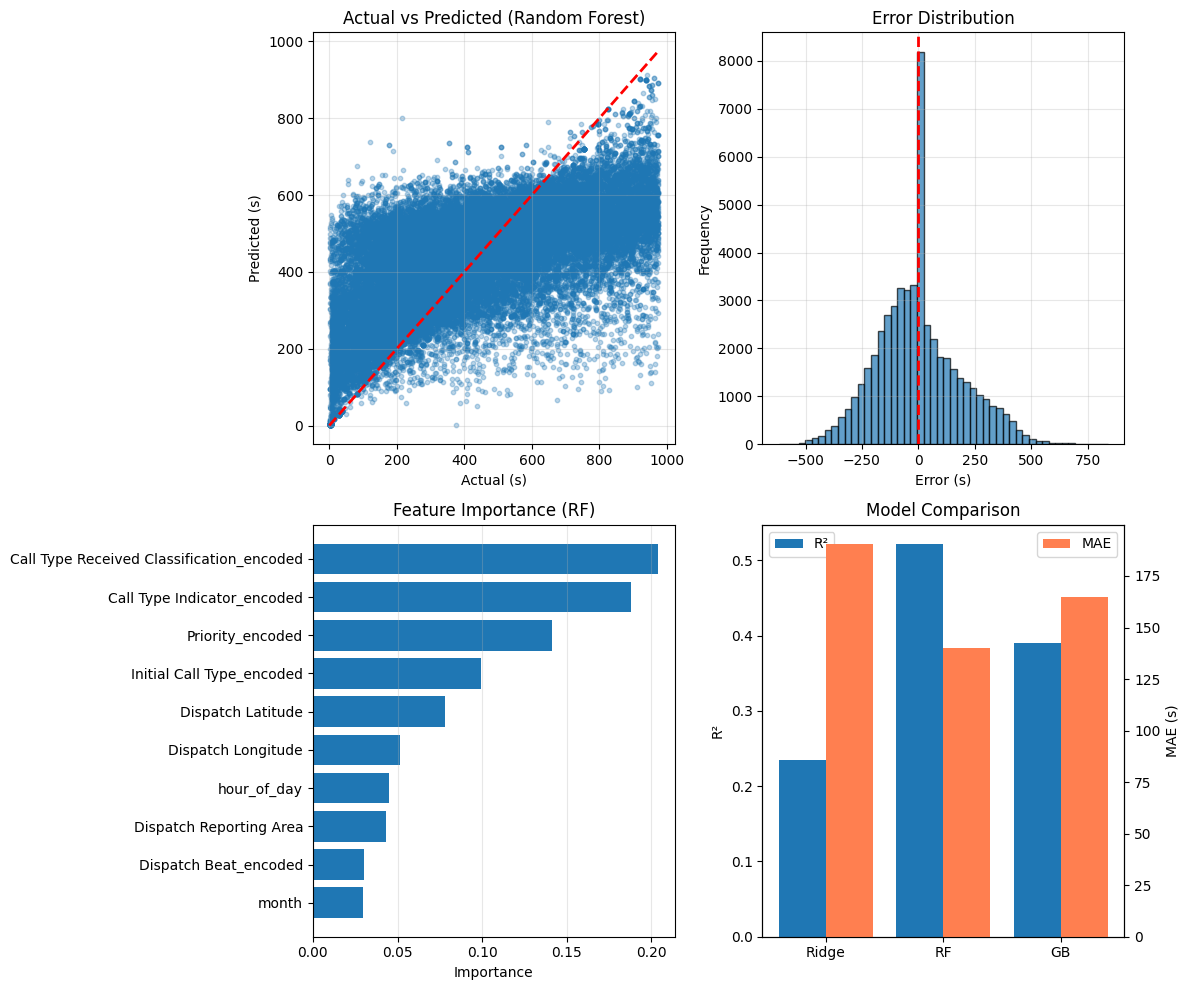

In [ ]:
## Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

best_pred = rf_pred_test if 'Random Forest' in best_model else (ridge_pred_test if 'Ridge' in best_model else gb_pred_test)
errors = y_test.values - best_pred

# Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_test, best_pred, alpha=0.3, s=10)
ax1.plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual (s)')
ax1.set_ylabel('Predicted (s)')
ax1.set_title(f'Actual vs Predicted ({best_model})')
ax1.grid(True, alpha=0.3)

# Error Distribution
ax2 = axes[0, 1]
ax2.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', lw=2)
ax2.set_xlabel('Error (s)')
ax2.set_ylabel('Frequency')
ax2.set_title('Error Distribution')
ax2.grid(True, alpha=0.3)

# Feature Importance
ax3 = axes[1, 0]
top_feat = rf_importance.head(10)
ax3.barh(range(len(top_feat)), top_feat['Importance'].values)
ax3.set_yticks(range(len(top_feat)))
ax3.set_yticklabels(top_feat['Feature'].values)
ax3.invert_yaxis()
ax3.set_xlabel('Importance')
ax3.set_title('Feature Importance (RF)')
ax3.grid(True, alpha=0.3, axis='x')

# Model Comparison
ax4 = axes[1, 1]
x = np.arange(3)
ax4.bar(x - 0.2, comparison_df['R² Score'], 0.4, label='R²')
ax4_twin = ax4.twinx()
ax4_twin.bar(x + 0.2, comparison_df['MAE (s)'], 0.4, color='coral', label='MAE')
ax4.set_xticks(x)
ax4.set_xticklabels(['Ridge', 'RF', 'GB'])
ax4.set_ylabel('R²')
ax4_twin.set_ylabel('MAE (s)')
ax4.set_title('Model Comparison')
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
## Summary
print(f"""
Best Model: {best_model}
  R²:   {comparison_df.loc[best_idx, 'R² Score']:.4f}
  RMSE: {comparison_df.loc[best_idx, 'RMSE (s)']:.1f}s ({comparison_df.loc[best_idx, 'RMSE (s)']/60:.1f} min)
  MAE:  {comparison_df.loc[best_idx, 'MAE (s)']:.1f}s ({comparison_df.loc[best_idx, 'MAE (s)']/60:.1f} min)
""")


Best Model: Random Forest
  R²:   0.5212
  RMSE: 186.0s (3.1 min)
  MAE:  140.0s (2.3 min)

